In [19]:
import os
import pandas as pd
from tensorflow import keras
from keras import models
import numpy as np
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import cv2

In [79]:
class recommender:
    def __init__(self, database_path, feature_path, model_path, label_map_path):
        # load the label_map
        self.label_map = []
        with open(label_map_path) as f:
            self.label_map = f.read().splitlines()
            
        # load the features of all images of database
        f = np.load(feature_path)
        self.all_features = f['arr_0']

        # load the database
        self.database = pd.read_csv(database_path)
        self.database.drop(['Unnamed: 0', 'feature'], axis=1, inplace=True)

        # load the model
        model_comp = models.load_model(model_path)

        self.encoder = models.Sequential()
        self.encoder.add(models.Model(model_comp.input, model_comp.layers[-2].output))
        self.encoder.add(keras.layers.GlobalAveragePooling2D())
        self.encoder.trainable = False

        self.classifier = models.Model(model_comp.layers[-1].layers[1].input,model_comp.layers[-1].output)
        self.classifier.trainable = False

        self.category_groups = self.database.groupby(self.database['category_label'])

        self.query_image = None
        self.neighbor_images = []
        self.label = None
        self.similarity = []

        print("Initialized recommender object with", len(self.database), "images among", len(self.category_groups), "categories")
        pass

    def get_feature(self,img_path):
        # load and scale the image
        img = keras.preprocessing.image.load_img(img_path, target_size=(224,224))
        img = keras.preprocessing.image.img_to_array(img)
        img = img.astype('float32')/255.0

        feature = self.encoder.predict(img, verbose=0)
        return feature

    def get_label(self, img_path, label_map = [0,1,10,2,3,4,5,6,7,8,9]):
        feat = self.get_feature(img_path)
        return self.__get_label(feat,label_map)

    def __get_label(self, feature, label_map = [0,1,10,2,3,4,5,6,7,8,9]):
        label = np.argmax(self.classifier.predict(np.expand_dims(feature,0), verbose=0))
        return label_map[label]
    
    def __get_neighbors(self,query, num_neighbors=9):
        #  compute neighbors of query in the database
        label = self.__get_label(query)
        all_samples = self.category_groups.get_group(label)
        neighs = [] # maintain top num_neighbors
        dists = []
        for i in all_samples.index:
            feat = self.all_features[i]
            sim = 1-cosine(query,feat)

            if len(neighs)<num_neighbors:
                neighs.append(i)
                dists.append(sim)
            else :
                for j in range(num_neighbors):
                    if dists[j]<sim:
                        neighs[j] = i
                        dists[j] = sim
                        break
        
        return neighs,dists, label
    
    def __random_choose(self):
        # randomly choose a query image from the database
        num_class = len(self.category_groups)
        label = np.random.choice(num_class)
        all_samples = self.category_groups.get_group(label)
        query_index = np.random.choice(all_samples.index)
        return self.database['image_name'][query_index], query_index
    
    def show(self):
        query_image = self.query_image
        neighbors = self.neighbor_images
    
        # show the query image and the neighbors
        if(len(neighbors)==0):
            print("No neighbors found! first call get_similar() to get similar images")
            return
        
        n = int(np.sqrt(len(neighbors)))
        plt.figure(figsize=(5*n,5*n))
        
        plt.subplot(n,n,1)
        plt.imshow(query_image)
        plt.axis('off')
        plt.title('Query Image' + '\n' + 'Predicted Category: ' + self.label_map[self.label])
        
        for i in range(1,n*n):
            plt.subplot(n,n,i+1)
            plt.imshow(neighbors[i])
            plt.axis('off')
            plt.title(f"Simmilarity: {self.similarity[i]*100:.2f} %")
        plt.show()
    
    def get_similar(self, query_image_path = None, num_neighbors=9):
        # get the similar recommendations for query image
    
        query_feat = 0
        if query_image_path is None:
            query_image_path, ind = self.__random_choose()
            query_feat = self.all_features[ind]
        else:
            query_feat = self.get_feature(query_image_path)

        neighs,dists, label = self.__get_neighbors(query_feat, num_neighbors)

        neighbor_images = []
        for i in neighs:
            neighbor_images.append( cv2.cvtColor( cv2.imread(self.database['image_name'][i]), cv2.COLOR_BGR2RGB ) )
        
        self.query_image = cv2.cvtColor( cv2.imread(query_image_path), cv2.COLOR_BGR2RGB )
        self.neighbor_images = neighbor_images
        self.label = label
        self.similarity = dists

        return self.query_image, neighbor_images, label

In [80]:
recommendations = recommender(database_path='features.csv', feature_path = 'features.npz', model_path = '../models/model_v5_0/', label_map_path='../dataset/anno/label_map2.txt')

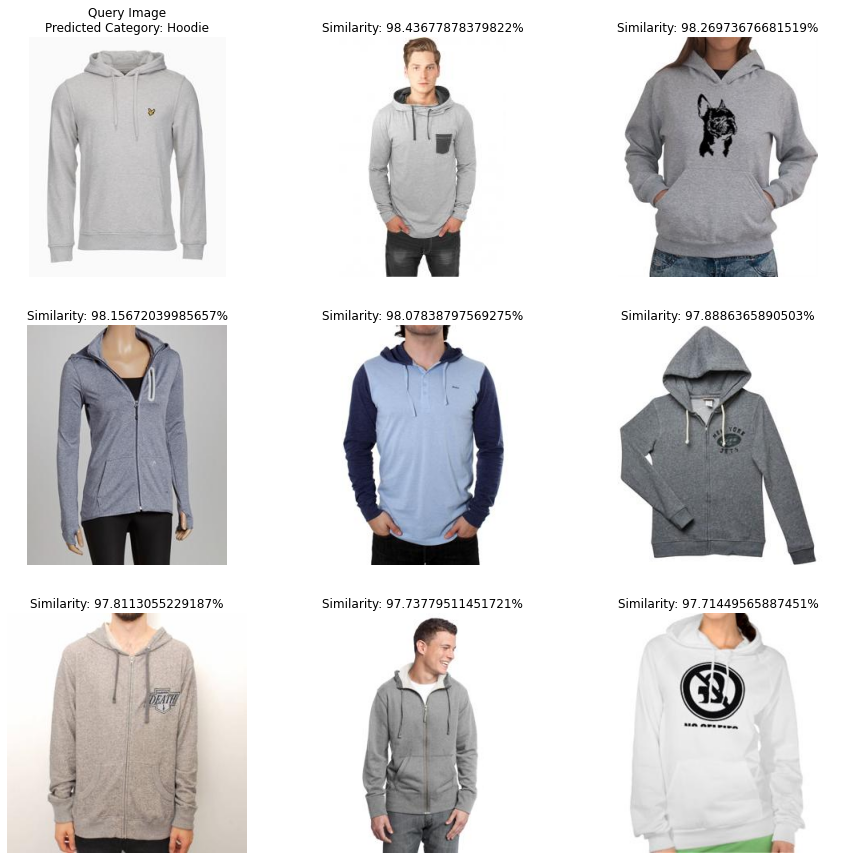

In [ ]:
recommendations.get_similar()
recommendations.show()